In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/mehdi/github/LSSutils')
import fitsio as ft
from lssutils.lab import AnaFast, MeanDensity
import healpy as hp
import lssutils.utils as ut
from lssutils.extrn.galactic import hpmaps

In [2]:
from lssutils.dataviz import setup_color

In [3]:
setup_color()

In [4]:
af = AnaFast()

In [5]:
def run_nbar(ng, nr, mask, syst, selection=None):
    nb = MeanDensity(ng, nr, mask, syst, selection=selection)
    nb.run()
    return nb.output

def read_wnn(path2file):
    w_ = ft.read(path2file)
    w_nn_ = np.median(w_['weight'], axis=1)
    w_nn = w_nn_ / w_nn_.mean()
    w_nn = w_nn.clip(0.5, 2.0)
    return ut.make_hp(256, w_['hpix'], w_nn, True)

def read_table(path2file):
    d_ = ft.read(path2file)
    ng = ut.make_hp(256, d_['hpix'], d_['label'])
    nr = ut.make_hp(256, d_['hpix'], d_['fracgood'])
    mask = ut.make_hp(256, d_['hpix'], 1.0) > 0.5
    syst = ut.make_hp(256, d_['hpix'], np.log(d_['features'][:, 0]))
    return ng, nr, mask, syst

def run_af(ng, nr, mask, syst, selection=None):
    dg = ut.make_overdensity(ng, nr, mask, selection_fn=selection)
    ds = ut.make_overdensity(syst, nr, mask, is_sys=True)
    
    cgg = af(dg, nr, mask)
    cgs = af(dg, nr, mask, map2=ds, weight2=nr, mask2=mask)
    css = af(ds, nr, mask)
    
    return (cgg, cgs, css)

In [11]:
comb = read_table('/home/mehdi/data/rongpu/imaging_sys/tables/nelg_features_combined_256.fits')
bmzls = read_table('/home/mehdi/data/rongpu/imaging_sys/tables/nelg_features_bmzls_256.fits')
sdecals = read_table('/home/mehdi/data/rongpu/imaging_sys/tables/nelg_features_sdecals_256.fits')


wcomb = read_wnn('/home/mehdi/data/rongpu/imaging_sys/regression/v2/sv3nn_elg_combined_256/nn-weights.fits')
#wsdecals = read_wnn('/home/mehdi/data/rongpu/imaging_sys/regression/v2/sv3nn_elg_sdecals_256/nn-weights.fits')
wbmzls = read_wnn('/home/mehdi/data/rongpu/imaging_sys/regression/v2/sv3nn_elg_bmzls_256/nn-weights.fits')

In [12]:
cls = {}
cls['Full (before)'] = run_af(comb[0], comb[1], comb[2], comb[3])
cls['Full (Wsys Full)'] = run_af(comb[0], comb[1],  comb[2], comb[3], selection=wcomb)


cls['BASS/MzLS (before)'] = run_af(comb[0], comb[1], bmzls[2]&comb[2], comb[3])
cls['BASS/MzLS  (Wsys Full)'] = run_af(comb[0], comb[1],  bmzls[2]&comb[2], comb[3], selection=wcomb)
cls['BASS/MzLS  (Wsys BMZLS S)'] = run_af(comb[0], comb[1],  bmzls[2]&comb[2], comb[3], selection=wbmzls)

fsky:  0.1391728719075521


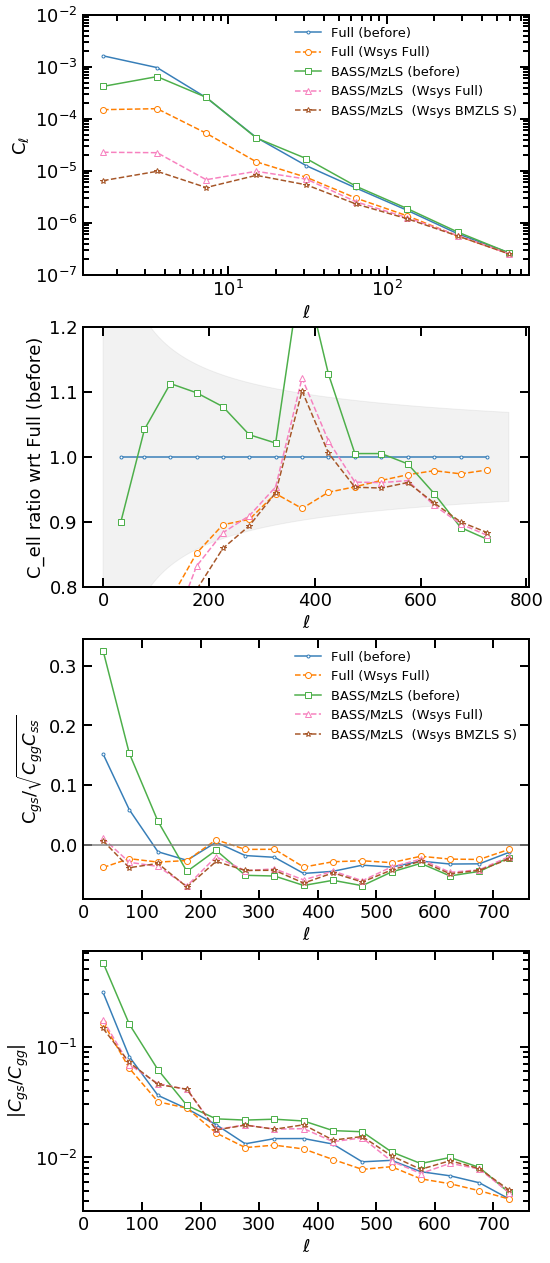

In [18]:
fg, ax = plt.subplots(nrows=4, figsize=(8, 22))
ax = ax.flatten()


fsky = sdecals[2].mean()
print('fsky: ', fsky)

def add_cgg(ax, cls):
    
    ref = 'Full (before)'#'BASS/MzLS  (Wsys BMZLS S)'
    lbins = np.arange(1., 769., 50)
    lb_, clb_ = ut.histogram_cell(cls[ref][0]['cl'], bins=lbins)


    le = np.arange(cls[ref][0]['cl'].size)
    err = 1./np.sqrt((2.*le+1.)*fsky)
    
    mk = ['.', 'o', 's', '^', '*', '+']
    
    for i, (ni, cli) in enumerate(cls.items()):
        lsi = '--' if 'Wsys' in ni else '-' 
        kw = dict(ls=lsi, marker=mk[i], mfc='w')
        
        lb, clb = ut.histogram_cell(cli[0]['cl'])
        ax[0].loglog(lb, clb, label=f'{ni}', **kw)
            
        lb, clb = ut.histogram_cell(cli[0]['cl'], bins=lbins)
        ax[1].plot(lb, clb/clb_, label=f'{ni}', **kw)
        
        clr_ = cli[1]['cl']/np.sqrt(cls['Full (before)'][0]['cl']*cls['Full (before)'][2]['cl'])
        lbr, clr = ut.histogram_cell(clr_, bins=lbins)
        ax[2].plot(lbr, clr, label=f'{ni}', **kw)
        
        lbr, clx = ut.histogram_cell(abs(cli[1]['cl']/cls['Full (before)'][0]['cl']), bins=lbins)
        ax[3].plot(lbr, clx, label=f'{ni}', **kw)
        

    ax[1].fill_between(le, 1-err, 1+err, alpha=0.1, 
                       color='grey', label=r'1/sqrt[(2$\ell$+1)fsky]')
#     ax[3].plot(le, cls[ref][0]['cl']*err, color='k', alpha=0.2)
    
    ax[2].axhline(0.0, ls='-', color='grey')

    ax[0].legend()    
    ax[2].legend()
    ax[0].set(ylim=(1.0e-7, 1.0e-2), xlabel=r'$\ell$', ylabel=r'C$_{\ell}$')
    
    ax[1].set(ylim=(0.8, 1.2), xlabel=r'$\ell$', ylabel=r'C_ell ratio wrt Full (before)')   
    ax[2].set(xlabel=r'$\ell$', ylabel=r'C$_{gs}/\sqrt{C_{gg}C_{ss}}$')
    ax[3].set(xlabel=r'$\ell$', ylabel=r'$|C_{gs}/C_{gg}|$', yscale='log')

    
add_cgg(ax, cls)

# Mean Density

In [21]:
ebv = comb[3]
nbars = {}
nbars['Full (before)'] = run_nbar(comb[0], comb[1], comb[2], ebv)
nbars['DECaLS S (before)'] = run_nbar(comb[0], comb[1], sdecals[2], ebv)
nbars['BASS/MzLS (before)'] = run_nbar(comb[0], comb[1], bmzls[2]&comb[2], ebv)
nbars['Full (Wsys Full)'] = run_nbar(comb[0], comb[1],  comb[2], ebv, wcomb)
nbars['DECaLS S (Wsys Full)'] = run_nbar(comb[0], comb[1],  sdecals[2], ebv, wcomb)
nbars['DECaLS S (Wsys DECaLS S)'] = run_nbar(comb[0], comb[1],  sdecals[2], ebv, wsdecals)

Text(0, 0.5, 'Mean Density')

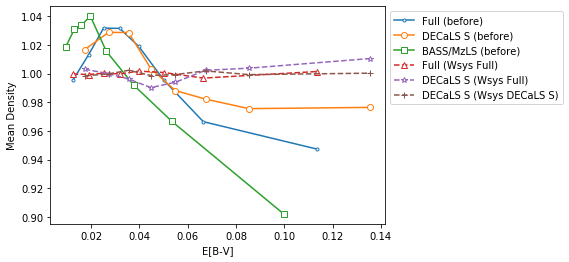

In [15]:
mk = ['.', 'o', 's', '^', '*', '+']
i = 0
for ni, nbari in nbars.items():
    lsi = '--' if 'Wsys' in ni else '-' 
    plt.plot(nbari['bin_avg'], nbari['nnbar'], label=f'{ni}', ls=lsi, marker=mk[i], mfc='w')
    i += 1

plt.legend(bbox_to_anchor=(1., 1.))
# plt.ylim(1.0e-7, 1.0e-2)
plt.xlabel('E[B-V]')
plt.ylabel('Mean Density')

In [17]:
lh = hpmaps.logHI()

/home/mehdi/github/LSSutils/lssutils/extrn/galactic/hpmaps.py:86: UserWarning: upgrading/downgrading HI column density
  if nside_out!= nside_in:warnings.warn('upgrading/downgrading HI column density')


In [19]:
lh.map

array([20.80716263, 20.7943978 , 20.77625721, ..., 20.97764578,
       20.95542353, 20.98900219])

In [21]:
logh = lh.map
h = 10**logh

In [22]:
from scipy.stats import pearsonr, spearmanr

In [31]:
for sys_i in [logh, h]:
    print(f'{pearsonr(comb[0][comb[2]], sys_i[comb[2]])[0]:.3f}', end=' ')
    print(f'{spearmanr(comb[0][comb[2]], sys_i[comb[2]])[0]:.3f}')    

-0.265 -0.278
-0.290 -0.278


[Text(0.5, 0, 'HI')]

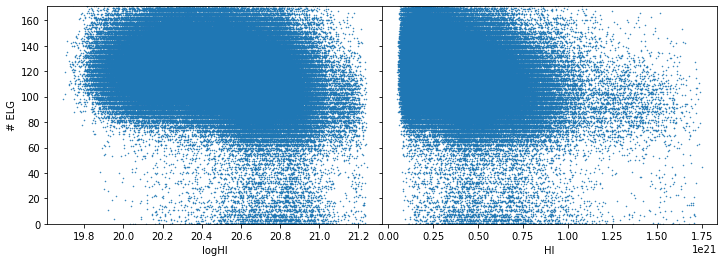

In [36]:
fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

ax[0].scatter(logh[comb[2]], comb[0][comb[2]], 1., marker='.')
ax[1].scatter(h[comb[2]], comb[0][comb[2]], 1., marker='.')

ax[0].set_ylim(*np.percentile(comb[0][comb[2]], [0, 99]))

ax[0].set(xlabel='logHI', ylabel='# ELG')
ax[1].set(xlabel='HI')

In [37]:
nbars = {}
nbars['Full (before)'] = run_nbar(comb[0], comb[1], comb[2], h)
nbars['DECaLS S (before)'] = run_nbar(comb[0], comb[1], sdecals[2], h)
nbars['BASS/MzLS (before)'] = run_nbar(comb[0], comb[1], bmzls[2]&comb[2], h)
nbars['Full (Wsys Full)'] = run_nbar(comb[0], comb[1],  comb[2], h, wcomb)
nbars['DECaLS S (Wsys Full)'] = run_nbar(comb[0], comb[1],  sdecals[2], h, wcomb)
nbars['DECaLS S (Wsys DECaLS S)'] = run_nbar(comb[0], comb[1],  sdecals[2], h, wsdecals)

Text(0, 0.5, 'Mean Density')

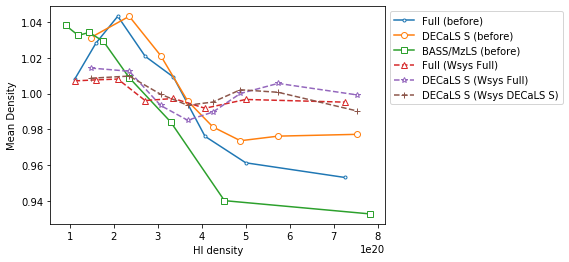

In [38]:
mk = ['.', 'o', 's', '^', '*', '+']
i = 0
for ni, nbari in nbars.items():
    lsi = '--' if 'Wsys' in ni else '-' 
    plt.plot(nbari['bin_avg'], nbari['nnbar'], label=f'{ni}', ls=lsi, marker=mk[i], mfc='w')
    i += 1

plt.legend(bbox_to_anchor=(1., 1.))
# plt.ylim(1.0e-7, 1.0e-2)
plt.xlabel('HI density')
plt.ylabel('Mean Density')

In [39]:
nbars = {}
nbars['Full (before)'] = run_nbar(comb[0], comb[1], comb[2], logh)
nbars['DECaLS S (before)'] = run_nbar(comb[0], comb[1], sdecals[2], logh)
nbars['BASS/MzLS (before)'] = run_nbar(comb[0], comb[1], bmzls[2]&comb[2], logh)
nbars['Full (Wsys Full)'] = run_nbar(comb[0], comb[1],  comb[2], logh, wcomb)
nbars['DECaLS S (Wsys Full)'] = run_nbar(comb[0], comb[1],  sdecals[2], logh, wcomb)
nbars['DECaLS S (Wsys DECaLS S)'] = run_nbar(comb[0], comb[1],  sdecals[2], logh, wsdecals)

Text(0, 0.5, 'Mean Density')

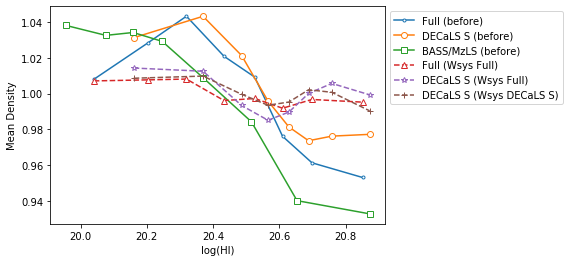

In [40]:
mk = ['.', 'o', 's', '^', '*', '+']
i = 0
for ni, nbari in nbars.items():
    lsi = '--' if 'Wsys' in ni else '-' 
    plt.plot(nbari['bin_avg'], nbari['nnbar'], label=f'{ni}', ls=lsi, marker=mk[i], mfc='w')
    i += 1

plt.legend(bbox_to_anchor=(1., 1.))
# plt.ylim(1.0e-7, 1.0e-2)
plt.xlabel('log(HI)')
plt.ylabel('Mean Density')